# Pixel induced current
In this notebook we load a track dataset and we calculate the current induced on the pixels placed at the anode.

In [1]:
# This is need so you can import larndsim without doing python setup.py install
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [2]:
from larndsim import consts, quenching, drifting, detsim, pixels_from_track, fee
from larndsim import indeces as i

import importlib
importlib.reload(detsim)
importlib.reload(drifting)
importlib.reload(quenching)
importlib.reload(consts)
importlib.reload(pixels_from_track)
importlib.reload(fee)
importlib.reload(i)


import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pickle
import numpy as np
import numba as nb
import pandas as pd

from numba import cuda
from math import ceil, sqrt, pi, exp, erf
from time import time

Here we load the dataset with the tracks and we store the column cols corresponding to the each variable.

In [3]:
tracks_np = pickle.load(open('qc_tpc_10k.p', 'rb'))
x_start, x_end = np.copy(tracks_np[:,i.x_start]), np.copy(tracks_np[:,i.x_end])
z_start, z_end = np.copy(tracks_np[:,i.z_start]), np.copy(tracks_np[:,i.z_end])
tracks_np[:,i.z_start], tracks_np[:,i.z_end] = x_start, x_end
tracks_np[:,i.x_start], tracks_np[:,i.x_end] = z_start, z_end

d_tracks_np = cuda.to_device(tracks_np)

In [4]:
threadsperblock = 256
blockspergrid = ceil(tracks_np.shape[0] / threadsperblock)

quenching.quench[blockspergrid,threadsperblock](d_tracks_np, consts.box)
drifting.drift[blockspergrid,threadsperblock](d_tracks_np)

## Charge distribution calculation
Here we calculate the current induced by each track on the pixels, taking into account longitudinal and transverse diffusion. The track segment is parametrized as:
\begin{align}
x'(r') &=x_s + \frac{\Delta x}{\Delta r}r'\\
y'(r') &=y_s + \frac{\Delta y}{\Delta r}r'\\
z'(r') &=z_s + \frac{\Delta z}{\Delta r}r',
\end{align}
where $\Delta r$ is the segment length. Here we assume $z$ as the drift direction.
The diffused charge distribution is calculated with the following integral:
\begin{equation}
\rho(x,y,z) = \frac{Q}{\sqrt{(2\pi)^3}\sigma_x\sigma_y\sigma_z\Delta r}\exp\left[-\frac{(x-x_s)^2}{2\sigma_x^2}-\frac{(y-y_s)^2}{2\sigma_y^2}-\frac{(z-z_s)^2}{2\sigma_z^2}\right]\int^{r'=\Delta r}_{r'=0}dr'\exp[-(ar'^2+br')],
\end{equation}
where 
\begin{align}
a &= \left[\left(\frac{\Delta x}{\Delta r}\right)^2\frac{1}{2\sigma_x^2} + \left(\frac{\Delta y}{\Delta r}\right)^2\frac{1}{2\sigma_y^2} + \left(\frac{\Delta z}{\Delta r}\right)^2\frac{1}{2\sigma_z^2} \right]\\
b &= -\left[\frac{(x-x_s)}{\sigma_x^2}\frac{\Delta x}{\Delta r}+
\frac{(y-y_s)}{\sigma_y^2}\frac{\Delta y}{\Delta r}+
\frac{(z-z_s)}{\sigma_z^2}\frac{\Delta z}{\Delta r}\right].
\end{align}

The simmetry of the transverse diffusion along the track allows to take a slice on the $xy$ plane and solve the integral once at a fixed $z$ coordinate (e.g. at $z_{m} = (z_s+z_e)/2$) and re-use it at other $z$ coordinates away from the endpoints (where $\rho(x,y,z)$ varies along $z$ so must be calculated at each $z$). 

In [5]:
selected_tracks = d_tracks_np[:100]

In [6]:
unique_eventIDs = np.unique(selected_tracks[:,i.eventID])
event_id_map = np.zeros_like(selected_tracks[:,i.eventID],dtype=np.int32)
for iev, evID in enumerate(selected_tracks[:,i.eventID]):
    event_id_map[iev] = np.where(evID == unique_eventIDs)[0][0]
d_event_id_map = cuda.to_device(event_id_map)

In [7]:
MAX_PIXELS = 50
MAX_ACTIVE_PIXELS = 20
active_pixels = np.zeros(shape=(selected_tracks.shape[0], MAX_ACTIVE_PIXELS, 2))
neighboring_pixels = np.full((selected_tracks.shape[0], MAX_PIXELS, 2), -1, dtype=np.int32)
d_active_pixels = cuda.to_device(active_pixels)
n_pixels_list = np.zeros(shape=(selected_tracks.shape[0]))
threadsperblock = 128
blockspergrid = ceil(selected_tracks.shape[0] / threadsperblock)
pixels_from_track.get_pixels[blockspergrid,threadsperblock](selected_tracks, 
                                                            d_active_pixels, 
                                                            neighboring_pixels, 
                                                            n_pixels_list)

In [8]:
# Here we calculate the track start times and the longest signal time
max_length = np.array([0])
track_starts = np.empty(selected_tracks.shape[0])
d_track_starts = cuda.to_device(track_starts)
threadsperblock = 128
blockspergrid = ceil(selected_tracks.shape[0] / threadsperblock)
detsim.time_intervals[blockspergrid,threadsperblock](d_track_starts, max_length,  d_event_id_map, selected_tracks)

In [9]:
# Here we calculate the induced current signals
signals = np.zeros((selected_tracks.shape[0], 
                    neighboring_pixels.shape[1], 
                    max_length[0]), dtype=np.float32)
threadsperblock = (4,4,4)
blockspergrid_x = ceil(signals.shape[0] / threadsperblock[0])
blockspergrid_y = ceil(signals.shape[1] / threadsperblock[1])
blockspergrid_z = ceil(signals.shape[2] / threadsperblock[2])
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)
d_signals = cuda.to_device(signals)

detsim.tracks_current[blockspergrid,threadsperblock](d_signals, 
                                                     neighboring_pixels, 
                                                     selected_tracks)

In [10]:
shapes = neighboring_pixels.shape
joined = neighboring_pixels.reshape(shapes[0]*shapes[1],2)
unique_pix = np.unique(joined, axis=0)[1:]

In [11]:
pixel_index_map = np.full((selected_tracks.shape[0], neighboring_pixels.shape[1]), -1)

for itr in range(neighboring_pixels.shape[0]):
    for ipix in range(neighboring_pixels.shape[1]):
        pID = neighboring_pixels[itr][ipix]
        if pID[0] >= 0 and pID[1] >= 0:
            try:
                index = np.where((unique_pix[:,0] == pID[0]) & (unique_pix[:,1] == pID[1]))[0][0]
            except IndexError:
                print("More pixels than maximum value")
            pixel_index_map[itr,ipix] = index
            
d_pixel_index_map = cuda.to_device(pixel_index_map)

In [12]:
pixels_signals = np.zeros((len(unique_pix),len(consts.time_ticks)*len(unique_eventIDs)))
d_pixels_signals = cuda.to_device(pixels_signals)

In [13]:
pix_signals = [{} for i in range(len(unique_pix))]
for isig in range(d_signals.shape[0]):
    for ipix in range(d_signals.shape[1]):
        pix_signals[d_pixel_index_map[isig,ipix]][int(d_track_starts[isig]//consts.t_sampling)] = d_signals[isig,ipix]

In [14]:
threadsperblock = (4,4,4)
blockspergrid_x = ceil(d_signals.shape[0] / threadsperblock[0])
blockspergrid_y = ceil(d_signals.shape[1] / threadsperblock[1])
blockspergrid_z = ceil(d_signals.shape[2] / threadsperblock[2])
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)
detsim.sum_pixel_signals[blockspergrid,threadsperblock](d_pixels_signals, 
                                                        d_signals, 
                                                        d_track_starts, 
                                                        d_pixel_index_map)

In [15]:
currents = np.sum(d_pixels_signals,axis=1)*consts.t_sampling/consts.e_charge

In [16]:
time_ticks = np.linspace(0,len(unique_eventIDs)*consts.time_interval[1]*2,d_pixels_signals.shape[1]+1)

In [17]:
integral_list = np.zeros((d_pixels_signals.shape[0], fee.MAX_ADC_VALUES))
adc_ticks_list = np.zeros((d_pixels_signals.shape[0], fee.MAX_ADC_VALUES))
threadsperblock = 32
blockspergrid_x = ceil(d_pixels_signals.shape[0] / threadsperblock)
blockspergrid = (blockspergrid_x, blockspergrid_y)
fee.get_adc_values[blockspergrid,threadsperblock](d_pixels_signals, 
                                                  time_ticks, 
                                                  integral_list, 
                                                  adc_ticks_list,
                                                  0)

In [18]:
adc_list = fee.digitize(integral_list)

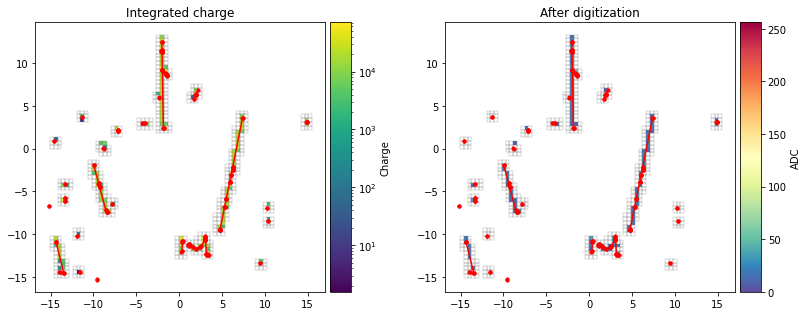

In [19]:
%matplotlib inline
cmap = cm.viridis

norm_curr = mpl.colors.LogNorm(vmin=min(currents[currents>0]), vmax=max(currents))
m_curr = cm.ScalarMappable(norm=norm_curr, cmap=cmap)

cmap = cm.Spectral_r
norm = mpl.colors.Normalize(vmin=0, vmax=256)
m = cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots(1,2,figsize=(13,8))
plt.subplots_adjust(wspace=0.3)
for it,t in enumerate(selected_tracks):
    ax[0].plot((t[i.x_start], t[i.x_end]), 
            (t[i.y_start], t[i.y_end]),
            c='r',
            zorder=10)
    ax[0].scatter((t[i.x_start], t[i.x_end]), 
               (t[i.y_start], t[i.y_end]),
               c='r',
               s=10,
               zorder=10)
    ax[1].plot((t[i.x_start], t[i.x_end]), 
            (t[i.y_start], t[i.y_end]),
            c='r',
            zorder=10)
    ax[1].scatter((t[i.x_start], t[i.x_end]), 
               (t[i.y_start], t[i.y_end]),
               c='r',
               s=10,
               zorder=10)

for ip, p in enumerate(unique_pix):
    x_rect = p[0]*consts.pixel_size[0]+consts.tpc_borders[0][0]
    y_rect = p[1]*consts.pixel_size[1]+consts.tpc_borders[1][0]
    c = sum(adc_list[ip]-fee.digitize(0))
    rect_curr = plt.Rectangle((x_rect, y_rect),
                     consts.pixel_size[0], consts.pixel_size[1],
                     linewidth=0.3, fc=m_curr.to_rgba(currents[ip]),
                     edgecolor='grey')
    ax[0].add_patch(rect_curr)
    
    if c > 0:    
        rect = plt.Rectangle((x_rect, y_rect),
                             consts.pixel_size[0], consts.pixel_size[1],
                             linewidth=0.3, fc=m.to_rgba(c),
                             edgecolor='grey', label='Pixel')
    else:
        rect = plt.Rectangle((x_rect, y_rect),
                     consts.pixel_size[0], consts.pixel_size[1],
                     linewidth=0.3, fc='none',
                     edgecolor='grey', label='Pixel')
    ax[1].add_patch(rect)

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

ax[0].set_title("Integrated charge")
ax[1].set_title("After digitization")

divider0 = make_axes_locatable(ax[0])
cax0 = divider0.append_axes("right", size="7%", pad=0.07)
divider1 = make_axes_locatable(ax[1])
cax1 = divider1.append_axes("right", size="7%", pad=0.07)
fig.colorbar(m_curr, ax=ax[0], cax=cax0, label='Charge')
fig.colorbar(m, ax=ax[1], cax=cax1, label='ADC')


In [22]:
pc = fee.export_to_hdf5(adc_list, adc_ticks_list, unique_pix, "qc_tpc_10k.h5")

Writing to HDF5...: 100%|██████████| 501/501 [00:00<00:00, 25125.80it/s]
